Dataset loaded. Shape: (303, 14)
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  target  
0    3.0  0.0  6.0       0  
1    2.0  3.0  3.0       2  
2    2.0  2.0  7.0       1  
3    3.0  0.0  3.0       0  
4    1.0  0.0  3.0       0  
Cleaned dataset shape: (297, 14)


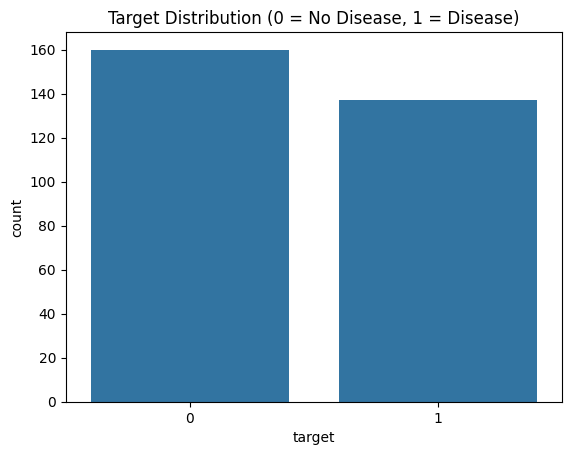

Train shape: (237, 13) Test shape: (60, 13)

Logistic Regression Results:
Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.81        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60



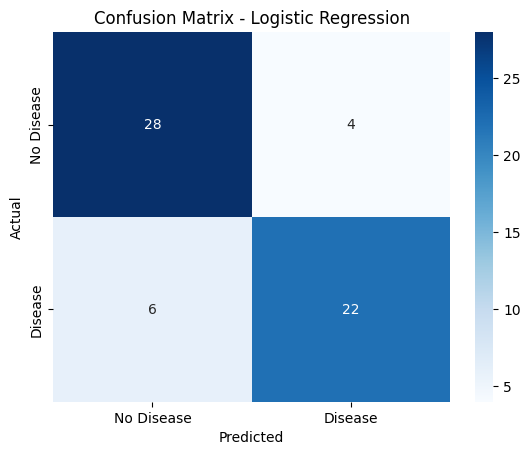


Random Forest Results:
Accuracy: 0.8666666666666667
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60



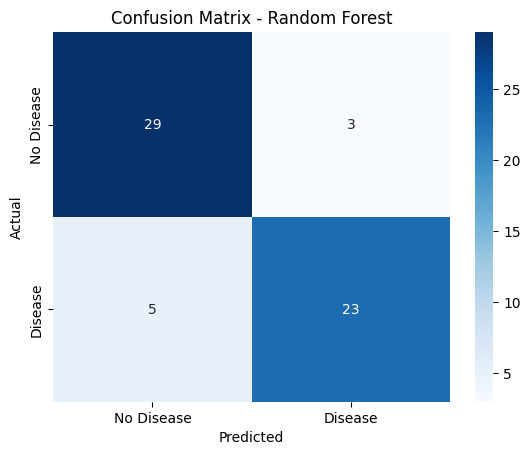


SVM Results:
Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        32
           1       0.88      0.79      0.83        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



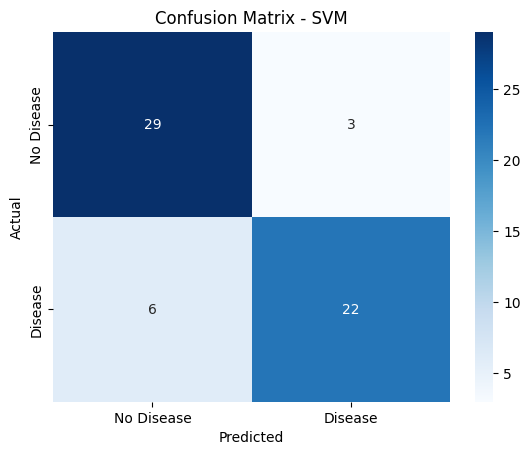


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Best Random Forest Accuracy: 0.85


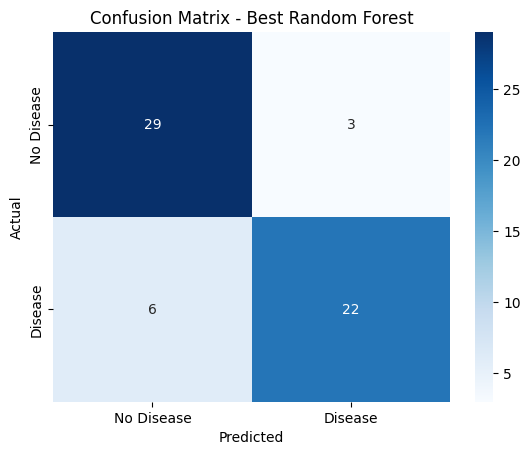

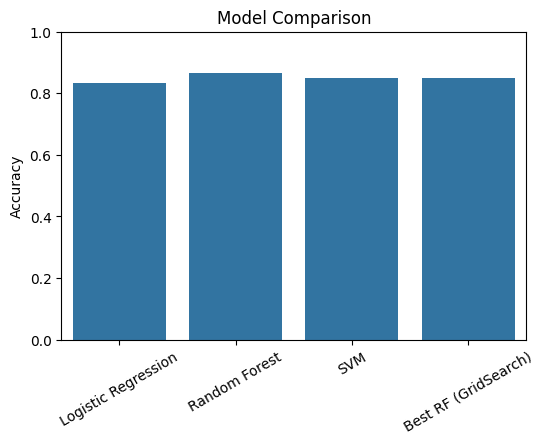

✅ Model and scaler saved in /models/
✅ Evaluation metrics saved in /results/


In [3]:
# ============================
# Heart Disease ML Pipeline
# ============================

import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

# ============================
# 1. Load Dataset
# ============================

# Unzip dataset
with zipfile.ZipFile("/content/heart+disease.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/heart_disease_data")

# Load Cleveland dataset
file_path = "/content/heart_disease_data/processed.cleveland.data"
df = pd.read_csv(file_path, header=None)

# Add column names
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalach", "exang", "oldpeak",
    "slope", "ca", "thal", "target"
]
df.columns = columns

print("Dataset loaded. Shape:", df.shape)
print(df.head())

# ============================
# 2. Data Preprocessing
# ============================

# Replace '?' with NaN and convert to numeric
df = df.replace('?', np.nan)
df = df.apply(pd.to_numeric)

# Drop rows with NaN values
df = df.dropna()

# Convert target: presence (1-4) → 1 (disease)
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

print("Cleaned dataset shape:", df.shape)

# ============================
# 3. Exploratory Data Analysis
# ============================

sns.countplot(x="target", data=df)
plt.title("Target Distribution (0 = No Disease, 1 = Disease)")
plt.show()

# ============================
# 4. Train-Test Split
# ============================

X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ============================
# 5. Feature Scaling
# ============================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================
# 6. Model Training
# ============================

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n{name} Results:")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Disease","Disease"],
                yticklabels=["No Disease","Disease"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ============================
# 7. Hyperparameter Tuning (Random Forest)
# ============================

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid.fit(X_train_scaled, y_train)

best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)
best_acc = accuracy_score(y_test, y_pred_best)

print("\nBest parameters for Random Forest:", grid.best_params_)
print("Best Random Forest Accuracy:", best_acc)

results["Best RF (GridSearch)"] = best_acc

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Disease","Disease"],
            yticklabels=["No Disease","Disease"])
plt.title("Confusion Matrix - Best Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ============================
# 8. Compare Models
# ============================

plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.title("Model Comparison")
plt.xticks(rotation=30)
plt.show()

# ============================
# 9. Save Model, Scaler, and Results
# ============================

os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Save final tuned Random Forest and scaler
joblib.dump(best_rf, "models/final_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
print("✅ Model and scaler saved in /models/")

# Save evaluation metrics
with open("results/evaluation_metrics.txt", "w") as f:
    for name, acc in results.items():
        f.write(f"{name}: {acc:.4f}\n")
    f.write(f"Best RF parameters: {grid.best_params_}\n")

print("✅ Evaluation metrics saved in /results/")
